### Stacking Ensemble with Neural Networks with Duration LSTM 

- Objective: using deep learning, improve results obtained in stacking and other ensemble notebooks

In [282]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
from math import sqrt
from numpy import dstack

In [283]:
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
from numpy import argmax
import tensorflow as tf

In [284]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.metrics import mean_squared_error
from keras.layers import LSTM
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from keras.layers.merge import concatenate

In [285]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from keras.models import load_model
from keras.utils import to_categorical
from numpy import dstack

In [286]:
#Loading final df from feature engineering notebook
final_df = pd.read_pickle('../../../../mkt_camp_data/final_df_pickle.pickle')
#final_df = final_df.drop(columns = ['Date'])

In [287]:
final_df = final_df[['Date','month', 'year', 'pdays', 'campaign', 'previous', 'emp.var.rate', 'age',
           'duration-rolling-avg-10', 'previous-rolling-avg-10', 'old_prospect_y-rolling-avg-10', 'duration']]

In [288]:
def scale_noncat_only_lstm(X):
    
    indx = X.Date
    X.drop(columns='Date', inplace=True)
    
    X_temp_noncat = X.select_dtypes(exclude=['int8'])
    X_temp_noncat = X_temp_noncat.drop(X_temp_noncat.filter(regex="-categorical").columns, axis=1)
    
    
    scaler = preprocessing.StandardScaler().fit(X_temp_noncat)
    X_transformed = pd.DataFrame(scaler.transform(X_temp_noncat), columns = X_temp_noncat.columns)
    
    X = X_transformed.merge(X, left_index=True, right_index=True, how='left', suffixes=('', '_rightdf'))
    X = X.drop(X.filter(regex="_rightdf").columns, axis=1)
    
    #X.index = indx
    
    return X, scaler

In [289]:
final_df, scaler = scale_noncat_only_lstm(final_df)

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()


In [290]:
def prep_df_lstm(df):
    y = df['duration']
    #X = df.drop(df.filter(regex='y').columns, axis=1)
    y = y.shift(1)
    #X = df.drop(columns='duration')
    #Dropping features based on y
    #X = X.drop(X.filter(regex="cust_acquisition_flag").columns, axis=1) 
    #X = X.drop(X.filter(regex="cust_retention_flag").columns, axis=1)
    #X = X.drop(X.filter(regex="prospect_conversion_flag").columns, axis=1)
    
    #Dropping linearly dependent features
    
    #X = df.drop(columns = ['new_lead'])

    X = df.copy()
     
    y = y.iloc[1:]
    X = X.iloc[1:]    
    
    names = list(df.columns)
    return X, y, names

In [291]:
X,y,names = prep_df_lstm(final_df)

In [292]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=4)

In [293]:
y_test_cache = pd.DataFrame(y_test)

In [318]:
y_test_cache.head()

duration
1614   0.866702
38584 -0.317364
12511 -0.008813
10200 -0.375218
7338  -0.313508

In [319]:
y_test_index

Int64Index([ 1614, 38584, 12511, 10200,  7338, 27083, 34486, 11895, 15135,
            32139,
            ...
             6911,  7728, 13009, 37322, 22343,  4428, 40229, 18958, 35430,
            18713],
           dtype='int64', length=8238)

In [294]:
X_train_index, X_test_index, y_train_index, y_test_index = X_train.index, X_test.index, y_train.index, y_test.index

In [295]:
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [296]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(32949, 1, 11) (32949,) (8238, 1, 11) (8238,)


In [297]:
# design network
model = Sequential()
model.add(LSTM(70, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [298]:
# fit network
history = model.fit(X_train, y_train, epochs=50, 
                    batch_size=72, validation_data=(X_test, y_test), 
                    verbose=2, shuffle=False)

Train on 32949 samples, validate on 8238 samples
Epoch 1/50
 - 10s - loss: 0.9752 - val_loss: 0.8695
Epoch 2/50
 - 8s - loss: 0.9668 - val_loss: 0.8679
Epoch 3/50
 - 9s - loss: 0.9657 - val_loss: 0.8674
Epoch 4/50
 - 8s - loss: 0.9652 - val_loss: 0.8672
Epoch 5/50
 - 8s - loss: 0.9649 - val_loss: 0.8671
Epoch 6/50
 - 8s - loss: 0.9646 - val_loss: 0.8670
Epoch 7/50
 - 8s - loss: 0.9644 - val_loss: 0.8669
Epoch 8/50
 - 8s - loss: 0.9642 - val_loss: 0.8668
Epoch 9/50
 - 9s - loss: 0.9640 - val_loss: 0.8668
Epoch 10/50
 - 9s - loss: 0.9639 - val_loss: 0.8667
Epoch 11/50
 - 10s - loss: 0.9637 - val_loss: 0.8667
Epoch 12/50
 - 10s - loss: 0.9636 - val_loss: 0.8667
Epoch 13/50
 - 10s - loss: 0.9634 - val_loss: 0.8667
Epoch 14/50
 - 10s - loss: 0.9633 - val_loss: 0.8667
Epoch 15/50
 - 10s - loss: 0.9632 - val_loss: 0.8667
Epoch 16/50
 - 10s - loss: 0.9630 - val_loss: 0.8667
Epoch 17/50
 - 10s - loss: 0.9629 - val_loss: 0.8667
Epoch 18/50
 - 10s - loss: 0.9627 - val_loss: 0.8667
Epoch 19/50
 - 

In [299]:
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

In [300]:
from numpy import concatenate
# invert scaling for forecast
inv_yhat = concatenate((yhat, X_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [301]:
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [302]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.901


In [321]:
from sklearn.metrics import r2_score
r2_score(inv_y, inv_yhat)

0.05392202190232431

In [306]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(inv_y, inv_yhat)

1.2899678758646083

In [307]:
#Loading final df from feature engineering notebook
final_df = pd.read_pickle('../../../../mkt_camp_data/final_df_pickle.pickle')
#final_df = final_df.drop(columns = ['Date'])

In [308]:
def prep_df_sc(df):
    y = df['y']
    X = df.drop(df.filter(regex='y').columns, axis=1)
    #y = y.shift(1)
    #X = df.drop(columns='duration')
    #Dropping features based on y
    X = X.drop(X.filter(regex="cust_acquisition_flag").columns, axis=1) 
    X = X.drop(X.filter(regex="cust_retention_flag").columns, axis=1)
    X = X.drop(X.filter(regex="prospect_conversion_flag").columns, axis=1)
   
    #X = X.set_index('Date')

    #Dropping linearly dependent features

    
    X = X.drop(columns = ['new_lead'])
     
    names = list(df.columns)
    return X, y, names

In [309]:
X,y,names = prep_df_sc(final_df)

In [310]:
y_test_cache.head()

duration
1614   0.866702
38584 -0.317364
12511 -0.008813
10200 -0.375218
7338  -0.313508

In [316]:
inv_y[:10]

array([ 8.3756712 ,  5.95971785,  6.58928224,  5.84167453,  5.9675874 ,
        8.24975832,  6.91980354,  4.70845862,  6.48697803, 10.57914656])

In [317]:
inv_yhat[:10]

array([6.9023322 , 6.69167105, 6.6431977 , 6.33999158, 6.11782991,
       7.12214674, 6.53842155, 5.50036469, 6.91756389, 6.88914872])

In [79]:
y_test_cache.reset_index(drop=0, inplace=True)

In [59]:
y_test_cache.set_index("index", inplace=True)

In [258]:
df = pd.read_pickle('../../../../mkt_camp_data/df_pickle.pickle')
#Excluding the duration variable as it cannot be used in our baseline
#df = df.drop(columns = ['duration'])

In [259]:
y_temp = pd.concat([y_test_cache, pd.Series(inv_yhat)], axis=1)
y_temp = y_temp.drop(columns='duration')
y_temp.set_index('index', inplace=True)
y_temp.columns = ['duration_pred']

In [260]:
X_new = y_temp.merge(df, how='inner', left_index=True, right_index=True)

In [261]:
from sklearn.neighbors import KNeighborsClassifier

In [262]:
X_new.shape

(8238, 22)

In [263]:
X_new.dtypes

duration_pred     float64
age                 int64
duration            int64
campaign            int64
pdays               int64
previous            int64
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
job                  int8
marital              int8
education            int8
default              int8
housing              int8
loan                 int8
contact              int8
month                int8
day_of_week          int8
poutcome             int8
y                    int8
dtype: object

In [264]:
def scale_noncat_only_lstm(X):
    
    #indx = X.Date
    #X.drop(columns='Date', inplace=True)
    
    X_temp_noncat = X.select_dtypes(exclude=['int8'])
    X_temp_noncat = X_temp_noncat.drop(X_temp_noncat.filter(regex="-categorical").columns, axis=1)
    
    
    scaler = preprocessing.StandardScaler().fit(X_temp_noncat)
    X_transformed = pd.DataFrame(scaler.transform(X_temp_noncat), columns = X_temp_noncat.columns)
    X_transformed.index  = X_temp_noncat.index

    X = X_transformed.merge(X, left_index=True, right_index=True, how='inner', suffixes=('', '_rightdf'))
    X = X.drop(X.filter(regex="_rightdf").columns, axis=1)
    
    #X.index = indx
    
    return X, scaler

In [265]:
X,scaler = scale_noncat_only_lstm(X_new)

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()


In [266]:
X.columns

Index(['duration_pred', 'age', 'duration', 'campaign', 'pdays', 'previous',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')

In [267]:
y = X['y']
X = X.drop(columns='y')

In [269]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=4)

In [270]:
from sklearn.model_selection import cross_val_score
clf = KNeighborsClassifier(n_neighbors = 20).fit(X_train, y_train)

scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')

print("Accuracy Mean and Standard Deviation on Training Set: %.3f, %.3f" %(np.mean(scores), np.std(scores)))

Accuracy Mean and Standard Deviation on Training Set: 0.897, 0.006


In [271]:
from sklearn.metrics import recall_score, precision_score, confusion_matrix
def print_scores(clf, X_test):
    y_pred = clf.predict(X_test)
    print("Scores on Test Dataset")
    print("Accuracy Score: ", accuracy_score(y_test, y_pred))
    print("Recall Score: ", recall_score(y_test, y_pred))
    print("Precision Score: ", precision_score(y_test, y_pred))

In [272]:
print_scores(clf, X_test)

Scores on Test Dataset
Accuracy Score:  0.9014563106796116
Recall Score:  0.25206611570247933
Precision Score:  0.7349397590361446


In [273]:
from yellowbrick.model_selection import LearningCurve
from yellowbrick.model_selection import ValidationCurve

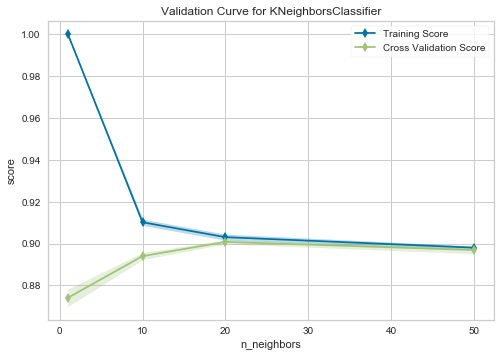

In [274]:
viz = ValidationCurve(
    clf, param_name="n_neighbors",
    param_range=[1,10,20,50], cv=3, scoring="accuracy"
)
# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof()

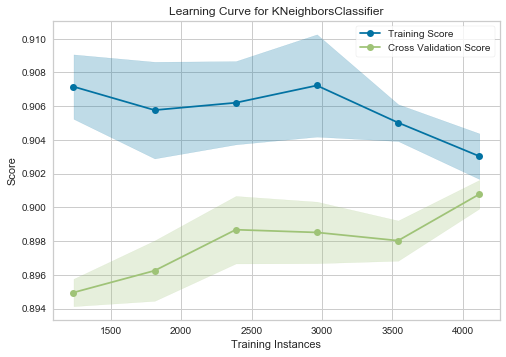

In [275]:
viz = LearningCurve(
    clf, cv=3, train_sizes=np.linspace(0.3, 1.0, 6),
    scoring='accuracy', n_jobs=-1)
viz.fit(X_train, y_train)
viz.poof()

In [276]:
def make_conf_matrix(clf, X_test):
    y_pred = clf.predict(X_test)
    cmx = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                   index = ['No', 'Yes'],
                   columns = ['No', 'Yes'])
    return cmx

In [277]:
def plot_conf_matrix(cmx):
    cmap = mpl.colors.ListedColormap(['green'])
    cmap1 = mpl.colors.ListedColormap(['red'])
    mask1 = (cmx.isin([cmx.iloc[0,0],cmx.iloc[1,1]]))
    
    f, ax = plt.subplots(figsize = (9,6))
    sns.heatmap(cmx, annot=True, fmt = 'g', cmap = cmap,
            cbar = False, annot_kws={"size": 20},
            ax=ax)
    sns.heatmap(cmx, mask=mask1 , cmap=cmap1, cbar=False)

    ax.set_ylabel('True label', fontsize = 15)
    ax.set_xlabel('Predicted label', fontsize = 15)
    ax.set_title("Confusion Matrix", fontsize = 20)
    plt.show()

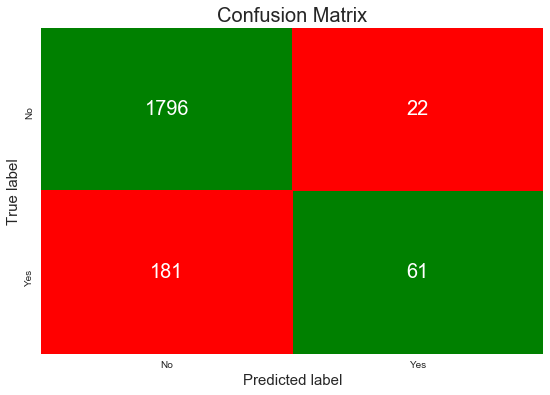

In [278]:
#Creating Confusion Matrix for Dirty Model:
cmx = make_conf_matrix(clf, X_test)
plot_conf_matrix(cmx)

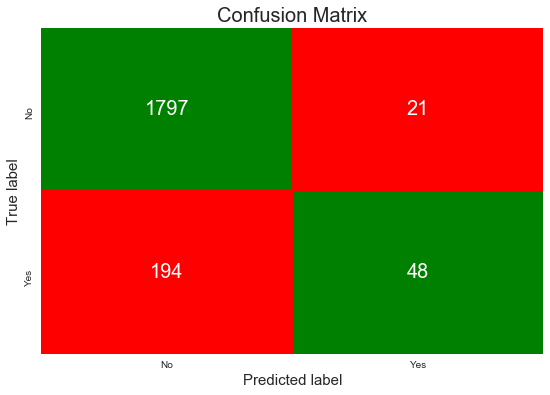

In [248]:
#Creating Confusion Matrix for Dirty Model:
cmx = make_conf_matrix(clf, X_test)
plot_conf_matrix(cmx)

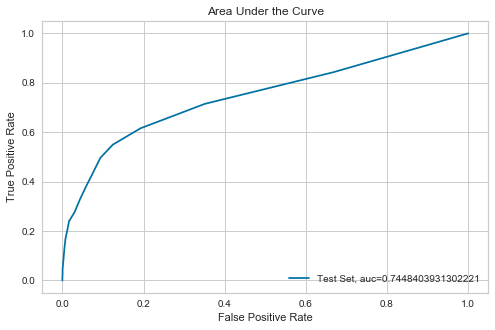

In [249]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize = (8,5))
plt.plot(fpr,tpr,label="Test Set, auc="+str(auc))
plt.title("Area Under the Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)
plt.show()

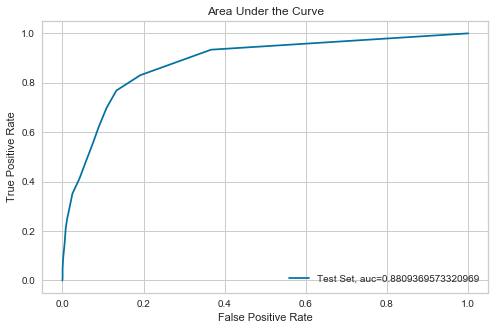

In [279]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize = (8,5))
plt.plot(fpr,tpr,label="Test Set, auc="+str(auc))
plt.title("Area Under the Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)
plt.show()

In [281]:
X[['duration', 'duration_pred']]

duration  duration_pred
1614   2.250982       1.049059
38584  0.436806      -0.352790
12511 -0.324842       0.098157
10200 -0.271259      -0.891623
7338  -0.420527      -1.282221
27083  1.037704       0.027850
34486 -0.225331      -0.216658
11895  0.892263      -1.482516
15135  0.808061       0.779308
32139 -0.631033       0.530937
33124  1.807006      -0.896626
24884  0.080859       0.097704
34516 -0.565967       0.516972
29579 -0.152610      -1.103436
26915  0.390877       0.094868
3556   0.103824       0.126835
36601  2.021340       0.252491
36107 -0.267432      -0.370813
41184  0.475079       1.285105
12632  0.306675      -0.825909
25731  2.078750       0.034980
18312 -0.167920       0.926263
3848  -0.087545       0.914136
10387 -0.699925      -0.935479
19630 -0.539176      -1.763221
18788 -0.841538      -0.493516
4988  -0.910431       1.776489
22740 -0.569795      -0.094786
35524 -0.041617      -0.671063
32523  1.125733       0.377262
...         ...            ...
17708 -0.386080      -1.524811
27825 -0.458801      -1.446993
25132 -0.489420      -1.093894
12154 -0.064581      -1.072238
29571 -0.910431      -0.848293
389    2.951392       1.678770
4485   1.496989       0.991888
25480 -0.508557      -0.210632
19014 -0.661652       1.495209
32990 -0.481765       0.597612
34113 -0.240640      -0.714919
21077 -0.745854      -0.609465
11224 -0.435836      -0.771400
5416  -0.608068      -0.711703
33768  0.119133       0.456550
37721 -0.389908      -1.134107
25246 -0.680789       0.688798
32243 -0.657824      -1.376411
36345 -0.753509      -0.110417
32526  0.111479       1.091806
6911  -0.206194      -1.527473
7728   0.674103       1.729105
13009 -0.416700       0.000749
37322 -0.389908      -0.689166
22343 -0.286569       1.878012
4428   1.056841       1.462767
40229 -0.462628       1.213177
18958 -0.493247       0.939345
35430 -0.558312      -1.302870
18713 -0.730544      -1.804308

[8238 rows x 2 columns]

In [109]:
def scale_noncat_only(df):
    
    y = df['y']
    df = df.drop(columns='y')
    
    X_temp_noncat = df.select_dtypes(exclude=['int8'])
    X_temp_cat = df.select_dtypes(include=['int8'])
    
    scaler = preprocessing.StandardScaler().fit(X_temp_noncat)
    X_transformed = scaler.transform(X_temp_noncat)
    
    X = pd.concat([pd.DataFrame(X_transformed, columns = X_temp_noncat.columns), X_temp_cat], axis = 1)
    #X = X.drop(columns=['y'])
    
    #will work with numpy arrays
    y = np.array(y)
    X = np.array(X)
    
    return X, y, scaler

X, y, scaler = scale_noncat_only(X_new)

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

ValueError: Found input variables with inconsistent numbers of samples: [14820, 8238]

In [107]:
X.shape

(14820, 20)

In [28]:
def scale_noncat_only_sc(df):
    X_temp_noncat = df.select_dtypes(exclude=['int8'])
    X_temp_cat = df.select_dtypes(include=['int8'])
    scaler = preprocessing.StandardScaler().fit(X_temp_noncat)
    X_transformed = scaler.transform(X_temp_noncat)
    X = pd.concat([pd.DataFrame(X_transformed, columns =X_temp_noncat.columns), X_temp_cat], axis = 1)
    X = X.drop(columns=['y'])
    y = df['y']
    #will work with numpy arrays
    y = np.array(y)
    X = np.array(X)
    
    return X, y

#X, y = scale_noncat_only(df)

In [8]:
#Checking dtypes have loaded correctly (should return empty index)
df.select_dtypes(exclude = ['float64', 'int64', 'int8']).columns

Index([], dtype='object')

In [9]:
X.shape

(41188, 72)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 4)

Starting with Neural Networks

In [11]:
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

In [12]:
# fit model on dataset
def fit_model(X_train, y_train):
    # define model
    model = Sequential()
    model.add(Dense(6, input_dim=72, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit model
    model.fit(X_train, y_train, epochs=500, verbose=0)
    return model

In [13]:
# load models from file
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = 'models/model_' + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

In [14]:
n_members = 5
for i in range(n_members):
    # fit model
    model = fit_model(X_train, y_train)
    # save model
    filename = 'models/model_' + str(i + 1) + '.h5'
    model.save(filename)
    print('>Saved %s' % filename)

>Saved models/model_1.h5
>Saved models/model_2.h5
>Saved models/model_3.h5
>Saved models/model_4.h5
>Saved models/model_5.h5


In [15]:
from keras.models import load_model

In [16]:
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))

>loaded models/model_1.h5
>loaded models/model_2.h5
>loaded models/model_3.h5
>loaded models/model_4.h5
>loaded models/model_5.h5
Loaded 5 models


In [17]:
# evaluate standalone models on test dataset
for model in members:
    _, acc = model.evaluate(X_test, y_test, verbose=0)
    print('Model Accuracy: %.3f' % acc)

Model Accuracy: 0.895
Model Accuracy: 0.899
Model Accuracy: 0.897
Model Accuracy: 0.898
Model Accuracy: 0.899


In [18]:
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
        # make prediction
        yhat = model.predict(inputX, verbose=0)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

In [19]:
# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # fit standalone model
    model = LogisticRegression()
    model.fit(stackedX, inputy)
    return model

In [20]:
# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # make a prediction
    yhat = model.predict(stackedX)
    return yhat

In [21]:
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))

>loaded models/model_1.h5
>loaded models/model_2.h5
>loaded models/model_3.h5
>loaded models/model_4.h5
>loaded models/model_5.h5
Loaded 5 models


In [22]:
# evaluate standalone models on test dataset
for model in members:
    _, acc = model.evaluate(X_test, y_test, verbose=0)
    print('Model Accuracy: %.3f' % acc)

Model Accuracy: 0.895
Model Accuracy: 0.899
Model Accuracy: 0.897
Model Accuracy: 0.898
Model Accuracy: 0.899


In [23]:
# fit stacked model using the ensemble
model = fit_stacked_model(members, X_test, y_test)
# evaluate model on test set
yhat = stacked_prediction(members, model, X_test)
acc = accuracy_score(y_test, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

Stacked Test Accuracy: 0.900


In [24]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import accuracy_score
from keras.models import load_model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
from numpy import argmax

In [25]:
# define stacked model from multiple member input models
def define_stacked_model(members):
    # update all layers in all models to not be trainable
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            # make not trainable
            layer.trainable = False
            # rename to avoid 'unique layer name' issue
            layer.name = 'ensemble_' + str(i+1) + '_' + layer.name
    # define multi-headed input
    ensemble_visible = [model.input for model in members]
    # concatenate merge output from each model
    ensemble_outputs = [model.output for model in members]
    merge = concatenate(ensemble_outputs)
    hidden = Dense(10, activation='relu')(merge)
    output = Dense(1, activation='sigmoid')(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)
    # plot graph of ensemble
    plot_model(model, show_shapes=True, to_file='model_graph.png')
    # compile
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [26]:
def fit_stacked_model(model, inputX, inputy):
    # prepare input data
    X = [inputX for _ in range(len(model.input))]
    # fit model
    model.fit(X, inputy, epochs=300, verbose=0)

In [27]:
# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
    # prepare input data
    X = [inputX for _ in range(len(model.input))]
    # make prediction
    return model.predict(X, verbose=0)

In [28]:
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))

>loaded models/model_1.h5
>loaded models/model_2.h5
>loaded models/model_3.h5
>loaded models/model_4.h5
>loaded models/model_5.h5
Loaded 5 models


In [29]:
# define ensemble model
stacked_model = define_stacked_model(members)
# fit stacked model on test dataset
fit_stacked_model(stacked_model, X_test, y_test)
# make predictions and evaluate
yhat = predict_stacked_model(stacked_model, X_test)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(y_test, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

Stacked Test Accuracy: 0.887


In [30]:
#WHen using, make sure you do y_pred - y_true i.e. invert order:
#precision = as_keras_metric(tf.metrics.precision)
#recall = as_keras_metric(tf.metrics.recall)